In [365]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.ensemble import RandomForestRegressor

In [2]:
def custom_date_parser(x):
    return datetime.strptime(x, '%d-%m-%Y')


sales_data = pd.read_csv("Salesdata.csv", parse_dates= ["Date"], date_parser= custom_date_parser)
store_data = pd.read_csv("store.csv")
sales_data.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

In [3]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [4]:
store_data.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [5]:
df = pd.merge(left= sales_data, right= store_data, how= "left", on= "Store")
df.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

The columns are given in PascalCase. Let us convert these to snake_case by using the underscore method from the Inflection library.

In [7]:
import inflection

snakecase = lambda x : inflection.underscore(x)
new_columns = list(map(snakecase, df.columns))
print("The snake_case columns after renaming will be:  \n \n", new_columns)

#Renaming the columns in snake case
df.columns = new_columns

The snake_case columns after renaming will be:  
 
 ['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval']


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1. Handling Missing Values

In [9]:
df.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

<AxesSubplot:>

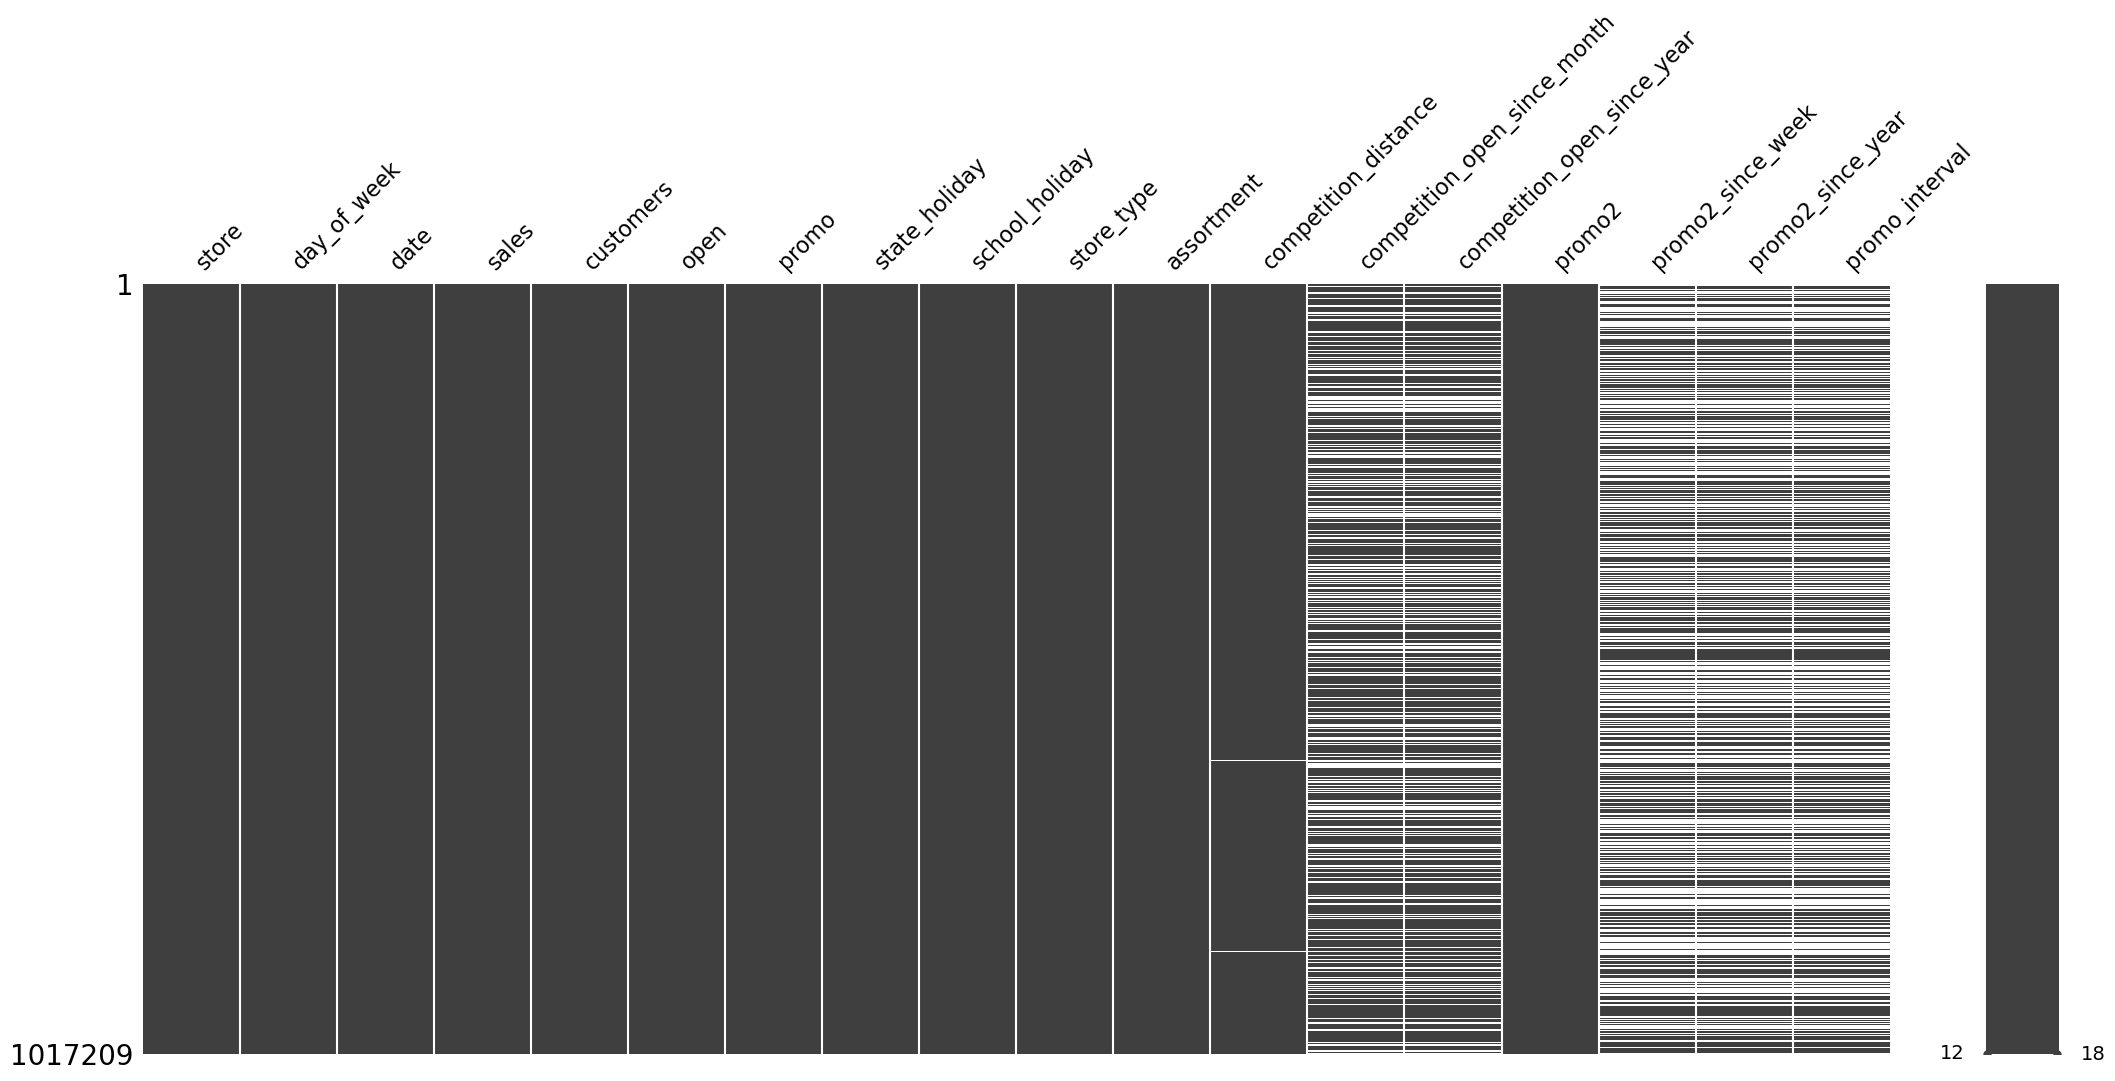

In [10]:
import missingno as msno

msno.matrix(df)

Visually, we can see that the CompetitionDistance has two horizontal stripes. It looks like it appears for two stores.

In [11]:
missing_values = df.isnull().sum()/ len(df) * 100
print(missing_values.sort_values(ascending = False))

promo_interval                  49.943620
promo2_since_year               49.943620
promo2_since_week               49.943620
competition_open_since_year     31.787764
competition_open_since_month    31.787764
competition_distance             0.259730
day_of_week                      0.000000
promo2                           0.000000
assortment                       0.000000
store                            0.000000
school_holiday                   0.000000
state_holiday                    0.000000
promo                            0.000000
open                             0.000000
customers                        0.000000
sales                            0.000000
date                             0.000000
store_type                       0.000000
dtype: float64


### 1.1 competition_distance

Text(0.5, 1.0, 'Competition Distance distribution')

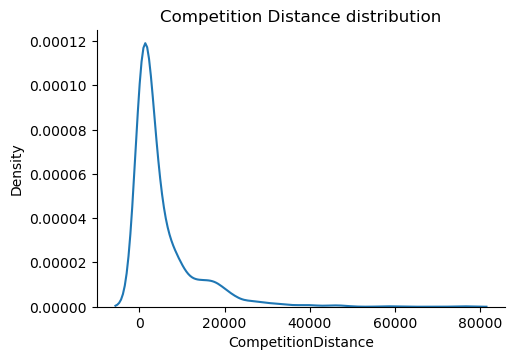

In [12]:
sns.displot(store_data, x = "CompetitionDistance", kind="kde", height=3.5, aspect=1.5)
plt.title("Competition Distance distribution")

Since, the distribution is right skewed, and has outliers, we will fill the nulls with median values.

In [13]:
#filling the null values of CompetitionDistance column with median competition distance
med_value = df.competition_distance.median()
print(f"The median competition distance between the stores is {med_value}")
df.competition_distance.fillna(med_value, inplace=True)

The median competition distance between the stores is 2330.0


### 1.2 competition_open_since[Week/year]

Text(0.5, 1.0, 'Competition open since year distribution')

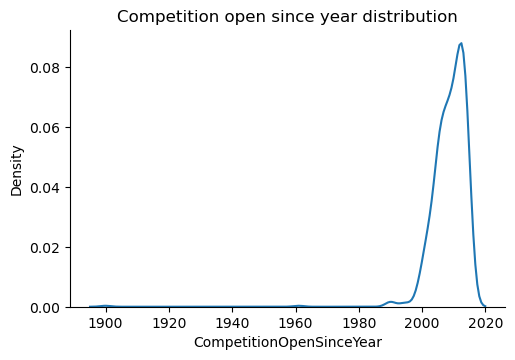

In [14]:
sns.displot(store_data, x = "CompetitionOpenSinceYear", kind="kde", height=3.5, aspect=1.5)
plt.title("Competition open since year distribution")

There are stores whose competitors are as old as 1900's. There are about 20 stores whose competitors opened their stores before 2000. So, let us fill the nulls with the modal value.

In [15]:
#filling the null values of CompetitionOpenSince[Week/year] with modal values
mode_value_year = df.competition_open_since_year.mode()[0]
mode_value_month = df.competition_open_since_month.mode()[0]
print(f"The most occuring competition open year is {mode_value_year}, and month is {mode_value_month}")
df.competition_open_since_year.fillna(mode_value_year, inplace=True)
df.competition_open_since_month.fillna(mode_value_month, inplace= True)

The most occuring competition open year is 2013.0, and month is 9.0


### 1.3 promo2_since_week, promo2_since_year, and promo_interval

In [16]:
# Promo2SinceWeek
print("Distribution of promo 2: \n", df['promo2'].value_counts())

Distribution of promo 2: 
 1    509178
0    508031
Name: promo2, dtype: int64


In [17]:
# Let's fill the Promo2SinceWeek and Promo2SinceYear as zero; indicating that stores did not participate for Promo2.
df['promo2_since_week'] = df['promo2_since_week'].fillna(0)
df['promo2_since_year'] = df['promo2_since_year'].fillna(0)

In [18]:
#Similarly, PromoInterval will be zero for non-participating stores
df['promo_interval'] = df['promo_interval'].fillna(0)


# Define the months dictionary
months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
          7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#Extracing the current month from Date column
df['month'] = df['date'].dt.month.apply(lambda x: months[x])

#If the current month is in the list of months of PromoInterval, then we'll create a new column IsPromo = 1 else 0.
df["is_promo"] = df.apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month'] in x['promo_interval'].split(",") else 0, axis = 1)

In [19]:
print("The total missing values in the dataset now is : ", df.isnull().sum().sum())

The total missing values in the dataset now is :  0


In [20]:
df.sample(10).T

,410169,101654,380717,573173,510336,781755,929780,932201,92346,963736
store,635,190,414,849,452,926,656,847,917,47
day_of_week,7,5,3,1,1,3,3,1,7,7
date,2014-06-29 00:00:00,2015-05-01 00:00:00,2014-07-30 00:00:00,2014-02-03 00:00:00,2014-03-31 00:00:00,2013-07-31 00:00:00,2013-03-20 00:00:00,2013-03-18 00:00:00,2015-05-10 00:00:00,2013-02-17 00:00:00
sales,0,0,6973,12327,6583,7630,3210,8612,0,0
customers,0,0,462,1152,508,499,329,1208,0,0
open,0,0,1,1,1,1,1,1,0,0
promo,0,1,1,1,1,1,1,1,0,0
state_holiday,0,a,0,0,0,0,0,0,0,0
school_holiday,0,0,1,0,0,1,0,0,0,0
store_type,a,a,d,c,a,d,d,c,a,a


## 2. Feature Engineering and Selection 

In [21]:
df['average_sales_per_customer'] = np.where(df.customers == 0, 0, df.sales/df.customers)

In [22]:
df['day'] = df['date'].apply(lambda x: x.day)
df['month'] = df['date'].apply(lambda x: x.month) #This will overwrite our 'month' column we created as jan, feb, mar...
df['year'] = df['date'].apply(lambda x: x.year)
#df['week_of_year'] = df['date'].apply(lambda x: x.weekofyear) #weekofyear is deprecated! Instead we'll use df.dt.isocalendar().week
df['week_of_year'] = df['date'].dt.isocalendar().week
df['year_week'] = df['year'].astype(str) + '-' + df['week_of_year'].astype(str).str.zfill(2)

- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened.<br>
We will combine these two columns into one by finding the time difference of CompetitionOpenSince[Month/Year] with Date column in terms of <b>months<b>.
- Because the above operation can produce negative values in the column, let us replace it with 0.

In [23]:
#No. of months from competition open since year/month to current month
df['competition_open'] = (df['year'] - df['competition_open_since_year'])* 12 - df['competition_open_since_month'] + df['month']

#Replacing the negative value with 0
df['competition_open'] = df['competition_open'].apply(lambda x: 0 if x < 0 else x)

- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2.
<br>
As before, we will combine these two columns into one in terms of <b>weeks<b>.

In [24]:
# Creating promo2_since column based on promo2_since_week, and promo2_since_year
#We know that 0 in promo2_since_year/week represents stores are not participating in the promo2 promotions. We will calculate the promo2_since in weeks.

#Creating the difference only when promo2_since_year is non-zero, else the difference should be zero as other stores aren't participating
promo2_conditional_difference = np.where(df['promo2_since_year'] != 0, df['year'] - df['promo2_since_year'], 0)

df['promo2_since'] = (promo2_conditional_difference) * 52 + df['week_of_year'] - df['promo2_since_week']
df['promo2_since'] = df['promo2_since'].apply(lambda x: max(x, 0))

Let us remove the redundant columns, after we the feature engineering. <br>
The columns are 
- competition_open_since_month
- competition_open_since_year
- promo2_since_week
- promo2_since_year
- promo_interval

In [25]:
#checking the sales when the stores are closed
sales_store_closed = sales_data[sales_data['Open'] == 0]['Sales'].sum()
print("Total sales when the stores were closed : ", sales_store_closed)

Total sales when the stores were closed :  0


As the sale is zero when stores are closed, it makes sense to remove rows that correspond to closed stores. 
This means the "open" column will have only the constant value 1; which has no information and the "open" column can be dropped.

In [26]:
#Let us create a dataframe "df_store_open" by filtering for "open" column as 1 (The stores are open).
df_store_open = df[df['open'] == 1]

In [27]:
df_store_open.shape

(844392, 27)

In [28]:
df_store_open.drop(['open', 'competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 
                   'promo2_since_year', 'promo_interval'],axis = 1, inplace= True)

Note that "date" column can be dropped as we already extracted information that column. We will keep this for now for the sake of data analysis.

In [29]:
df_store_open.sample(10).T

,942850,299077,342330,894686,523520,338880,902741,326135,46169,768302
store,346,63,356,127,256,704,377,1111,455,853
day_of_week,5,6,2,6,3,6,6,6,6,1
date,2013-03-08 00:00:00,2014-10-25 00:00:00,2014-09-09 00:00:00,2013-04-20 00:00:00,2014-03-19 00:00:00,2014-09-13 00:00:00,2013-04-13 00:00:00,2014-09-27 00:00:00,2015-06-20 00:00:00,2013-08-12 00:00:00
sales,6316,7358,4663,5181,9545,7779,5642,2551,9019,12071
customers,614,753,349,737,1222,738,760,212,576,1232
promo,1,0,0,0,1,0,0,0,0,1
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,0,0,1,0,0,0,0,0,0,1
store_type,a,c,d,d,a,d,a,a,d,a
assortment,c,c,c,a,c,c,c,a,c,a


In [30]:
#creating categorical column list
categorical_columns = ['day_of_week', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment',
                      'promo2', 'month', 'is_promo', 'day', 'year', 'week_of_year']

In [31]:
#checking the unique values in the categorical_columns and if all the data types are appropriate

for col in categorical_columns:
    print(f"The unique values in the column {col} is ",df_store_open[col].unique())

The unique values in the column day_of_week is  [5 4 3 2 1 7 6]
The unique values in the column promo is  [1 0]
The unique values in the column state_holiday is  ['0' 'a' 'b' 'c' 0]
The unique values in the column school_holiday is  [1 0]
The unique values in the column store_type is  ['c' 'a' 'd' 'b']
The unique values in the column assortment is  ['a' 'c' 'b']
The unique values in the column promo2 is  [0 1]
The unique values in the column month is  [ 7  6  5  4  3  2  1 12 11 10  9  8]
The unique values in the column is_promo is  [0 1]
The unique values in the column day is  [31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8
  7  6  5  4  3  2  1]
The unique values in the column year is  [2015 2014 2013]
The unique values in the column week_of_year is  <IntegerArray>
[31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13,
 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1, 52, 51, 50, 49, 48, 47, 46,
 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35

We can see that the state_holiday has string type '0' and integer type 0 in its column. We want everything in the string type.

In [32]:
df_store_open['state_holiday'] = df_store_open['state_holiday'].astype(str)
print(df_store_open['state_holiday'].unique())

['0' 'a' 'b' 'c']


## 3. Visualizations

### 3.1 Analysing Sales on State Holidays and School Holidays

<Figure size 800x800 with 0 Axes>

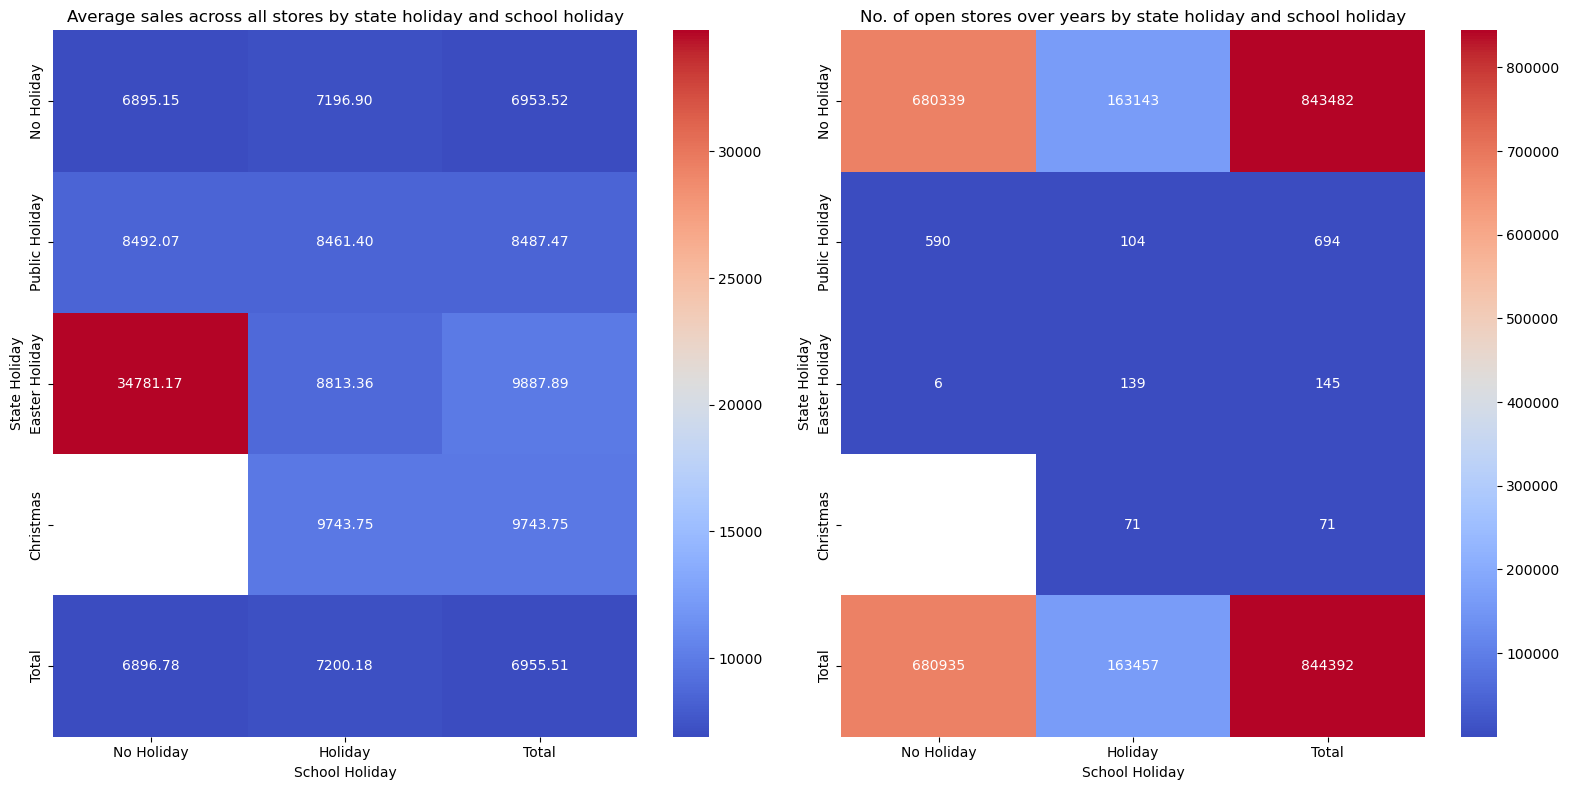

In [33]:
# Creating the pivot table of state_holiday vs sales with column and row totals
pivot_table_avg_sales = df_store_open.pivot_table(values='sales', index='state_holiday', columns='school_holiday', 
                                        aggfunc=['mean'], margins=True)
# Creating the pivot table of state_holiday vs count of sales with column and row totals
pivot_table_sales_count = df_store_open.pivot_table(values='sales', index='state_holiday', columns='school_holiday', 
                                        aggfunc=['count'], margins=True)


plt.figure(figsize=(8, 8))
fig , ax = plt.subplots(1,2, figsize = (16,8))

#Heatmap over the 1st pivot table
sns.heatmap(pivot_table_avg_sales, ax=ax[0], cmap="coolwarm", fmt = '.2f', annot=True, xticklabels=['No Holiday', 'Holiday', 'Total'], 
           yticklabels= ['No Holiday', 'Public Holiday', 'Easter Holiday', 'Christmas', 'Total'])
ax[0].set_title("Average sales across all stores by state holiday and school holiday")
ax[0].set_xlabel('School Holiday')
ax[0].set_ylabel('State Holiday')


#Heatmap over the 2nd pivot table
sns.heatmap(pivot_table_sales_count, ax=ax[1], cmap="coolwarm",fmt="0.0f", annot=True, xticklabels=['No Holiday', 'Holiday', 'Total'], 
           yticklabels= ['No Holiday', 'Public Holiday', 'Easter Holiday', 'Christmas', 'Total'])
ax[1].set_title("No. of open stores over years by state holiday and school holiday")
ax[1].set_xlabel('School Holiday')
ax[1].set_ylabel('State Holiday')

plt.tight_layout()
plt.show()

- The avg. sales are higher during the holidays i.e., Christmas, Easter, and Public holidays.
- Schools across all stores have compulsory holidays during Christmas eve, but not necessarily on other holidays.
- The Easter Holiday sales during No school holidays has highest average, and the goods are only sold on 6 different days over 3 years. Interestingly, it is the <b>store number 262</b> that was open and saw good sales. 

In [34]:
df_store_open[(df_store_open["state_holiday"] == 'b') & (df_store_open['school_holiday'] == 0)]

,store,day_of_week,date,sales,customers,promo,state_holiday,school_holiday,store_type,assortment,...,promo2,month,is_promo,average_sales_per_customer,day,year,week_of_year,year_week,competition_open,promo2_since
129601,262,1,2015-04-06,33655,5152,0,b,0,b,a,...,0,4,0,6.532415,6,2015,15,2015-15,23.0,15.0
132946,262,5,2015-04-03,38722,5132,1,b,0,b,a,...,0,4,0,7.545207,3,2015,14,2015-14,23.0,14.0
486731,262,1,2014-04-21,30848,5028,0,b,0,b,a,...,0,4,0,6.135243,21,2014,17,2014-17,11.0,17.0
490076,262,5,2014-04-18,35909,5063,1,b,0,b,a,...,0,4,0,7.092435,18,2014,16,2014-16,11.0,16.0
916006,262,1,2013-04-01,33326,5013,0,b,0,b,a,...,0,4,0,6.647915,1,2013,14,2013-14,0.0,14.0
919351,262,5,2013-03-29,36227,5069,1,b,0,b,a,...,0,3,0,7.146775,29,2013,13,2013-13,0.0,13.0


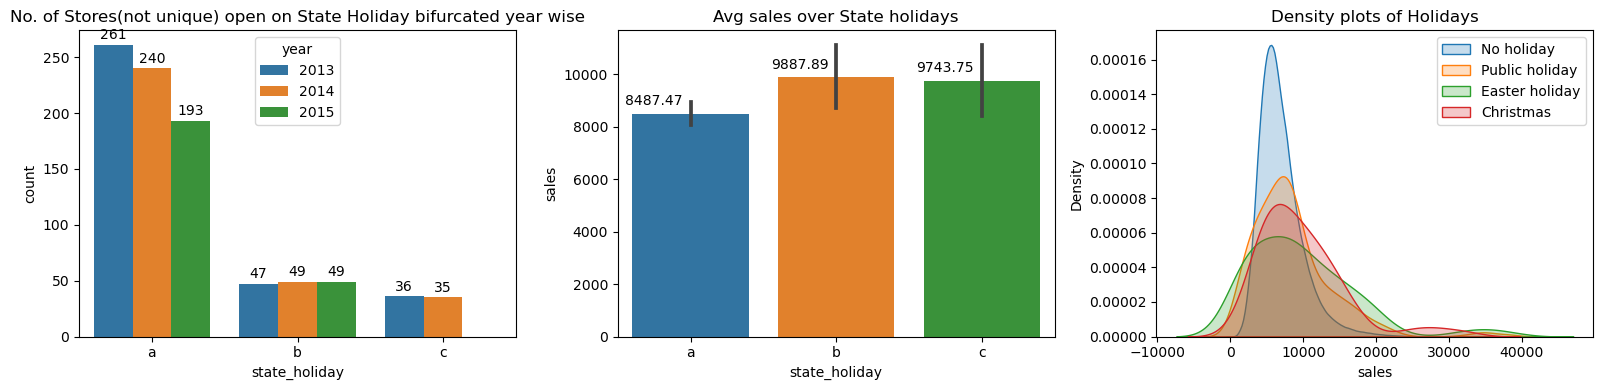

In [35]:
fig, ax = plt.subplots(1, 3, figsize = (16, 4))

#Count plot of state holidays bifurcated yearwise
sns.countplot(x = 'state_holiday', data = df_store_open[df_store_open['state_holiday'] != "0"], ax=ax[0], hue = 'year')
ax[0].set_title("No. of Stores(not unique) open on State Holiday bifurcated year wise")
for p in ax[0].patches:
    ax[0].annotate(format(p.get_height(), ".0f"), (p.get_x() + p.get_width()/2, p.get_height()), 
                   ha = 'center', va = 'center', xytext=(0, 7),  textcoords='offset points')
    
#Bar plot of State holiday vs Avg Sales
sns.barplot(x = 'state_holiday' , y = 'sales', data = df_store_open[df_store_open['state_holiday'] != "0"], ax = ax[1])
ax[1].set_title("Avg sales over State holidays")
for p in ax[1].patches:
    ax[1].annotate(format(p.get_height(), ".2f"), (p.get_x() + 0.15, p.get_height()), 
                  ha = "center", va = 'center', xytext = (0,9), textcoords = "offset points")
    

#Kernel density plot of State holiday
sns.kdeplot(x = df_store_open['sales'][df_store_open['state_holiday'] == "0"], ax = ax[2], shade= True, label = "No holiday")
sns.kdeplot(x = df_store_open['sales'][df_store_open['state_holiday'] == "a"], ax = ax[2], shade = True, label = "Public holiday")
sns.kdeplot(x = df_store_open['sales'][df_store_open['state_holiday'] == "b"], ax = ax[2], shade = True, label = "Easter holiday")
sns.kdeplot(x = df_store_open['sales'][df_store_open['state_holiday'] == "c"], ax = ax[2], shade = True, label = "Christmas")
ax[2].set_title("Density plots of Holidays")
plt.legend()
plt.tight_layout()

- Over 2.5 years, the number of stores(many repeated, not unique) has reduced during public holidays.
- The least number of stores open has been observed during Christmas. But the avg. sales has been higher on Christmas when compared during public holidays.
- As per the KDE plot, among the holidays; the Public holiday is consistant with least spread while the Easter holiday is scattered with most spread.

In [36]:
#Grouped by date, this finds the numbers of open stores along with other main features
df_state_holiday_open_stores = df_store_open[df_store_open['state_holiday'] != "0"].groupby('date').agg(
                            count_of_open_stores = ('state_holiday', 'count'),
                            avg_sales = ('sales', 'mean'),
                            total_customers = ('customers', 'sum'),
                            state_holiday = ('state_holiday', lambda x: ''.join(x.unique()))).reset_index()

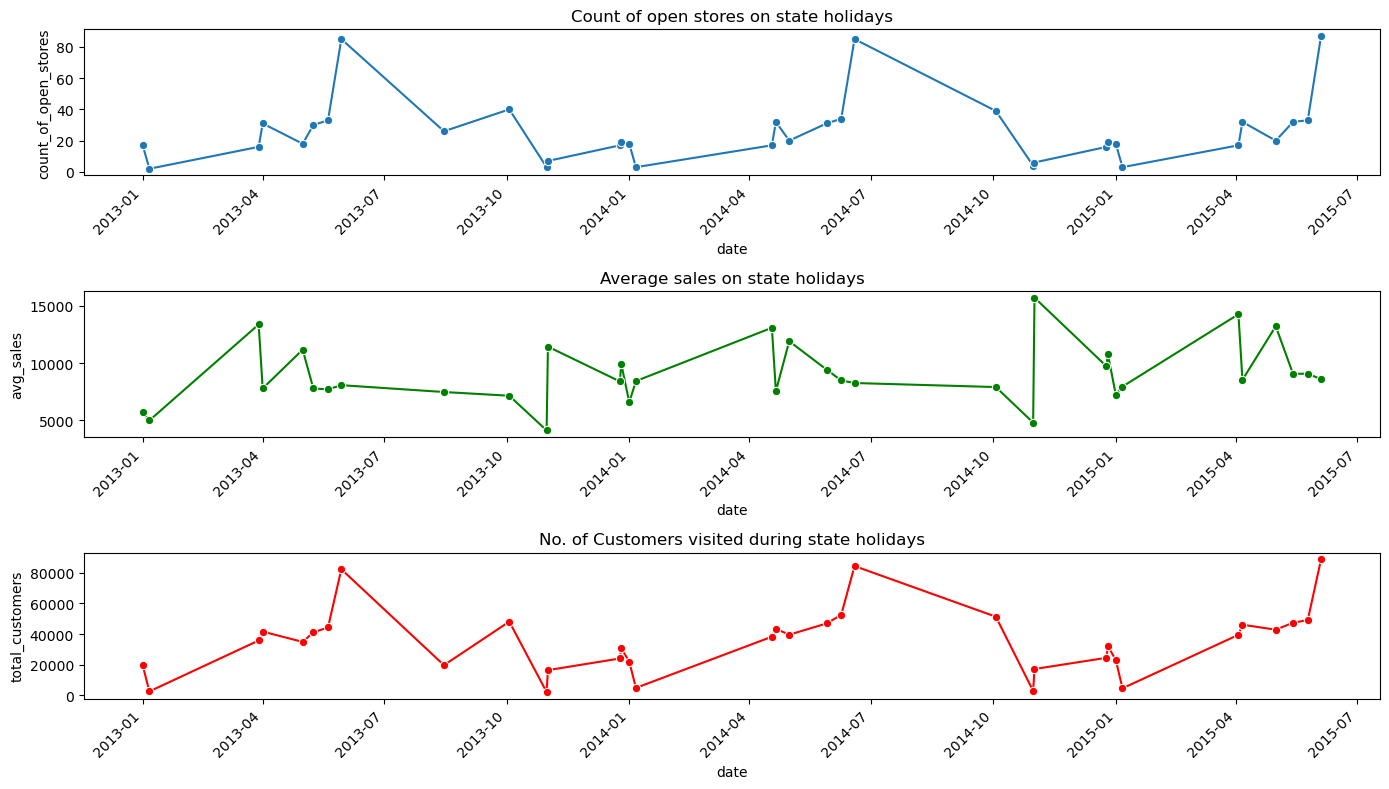

In [37]:
fig, ax = plt.subplots(3,1,figsize=(14,8))

#Plotting the number of open stores on state holidays
bar_plot_count = sns.lineplot(data=df_state_holiday_open_stores, x = 'date', y = 'count_of_open_stores', marker = 'o', ax=ax[0])
ax[0].set_title('Count of open stores on state holidays')

#Plotting the Avg. Sales on state holidays
bar_plot_sales = sns.lineplot(data = df_state_holiday_open_stores, x = 'date', y = 'avg_sales', marker = "o", ax = ax[1], color = 'g')
ax[1].set_title('Average sales on state holidays')

#Plotting the Avg. Sales on state holidays
bar_plot_sales = sns.lineplot(data = df_state_holiday_open_stores, x = 'date', y = 'total_customers', marker = "o", ax = ax[2], color = 'r')
ax[2].set_title('No. of Customers visited during state holidays')

# Rotate the x-axis labels for both plots
for axis in ax:
    for label in axis.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
        
# Show the plot
plt.tight_layout()
plt.show()

- There are 14 state holidays in 2013, 13 state holidays in 2014, and 8 state holidays in 2015 till June.
- We can observe that the peaked avg_sales on a particular day indicates the sales were higher even though the number of stores opened were less.
- We can also see that the 1st graph and 3rd graph has the exact same pattern.

### 3.2 Analysing Sales over Store type

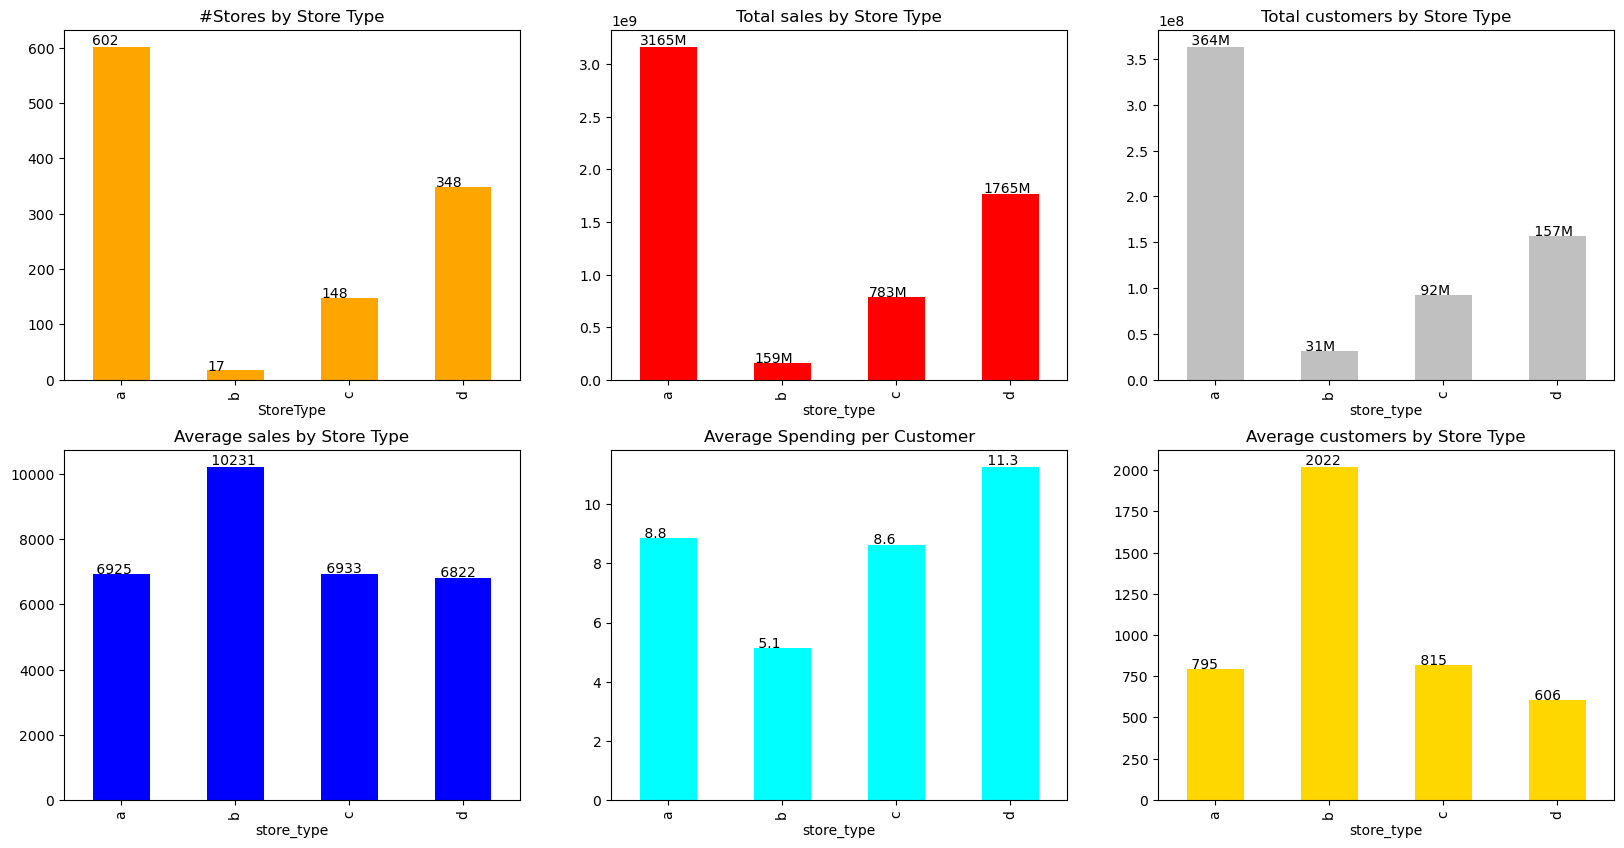

In [38]:
fig, ax = plt.subplots(2,3, figsize = (20,10))


store_data.groupby('StoreType')['Store'].count().plot(kind = 'bar', ax=ax[0,0], title = '#Stores by Store Type', color = 'orange')
for bar in ax[0,0].patches:
    ax[0,0].annotate(f'{bar.get_height()}', (bar.get_x()*1.005, bar.get_height()*1.005))


df_store_open.groupby('store_type')['sales'].sum().plot(kind = 'bar', ax=ax[0,1], title = 'Total sales by Store Type', color = 'red')
for bar in ax[0,1].patches:
    height = bar.get_height()
    ax[0,1].annotate(f'{height/1e6 :.0f}M', (bar.get_x()*1.005, bar.get_height()*1.005))
    

df_store_open.groupby('store_type')['customers'].sum().plot(kind = 'bar', ax = ax[0,2], title = "Total customers by Store Type", color = 'silver')
for bar in ax[0,2].patches:
    height = bar.get_height()
    ax[0,2].annotate(f'{height/1e6 : .0f}M', (bar.get_x()*1.005, height*1.005))
    
    
df_store_open.groupby('store_type')['sales'].mean().plot(kind = 'bar', ax = ax[1,0], title = "Average sales by Store Type", color = 'blue')
for bar in ax[1,0].patches:
    ax[1,0].annotate(f'{bar.get_height() : .0f}', (bar.get_x()*1.005 , bar.get_height()*1.005 ))
    

df_store_open.groupby('store_type')['average_sales_per_customer'].mean().plot(kind = 'bar', ax = ax[1,1], title = "Average Spending per Customer", color = 'cyan')
for bar in ax[1,1].patches:
    ax[1,1].annotate(f'{bar.get_height() : .1f}', (bar.get_x()*1.005 , bar.get_height()*1.005 ))
    
    
df_store_open.groupby('store_type')['customers'].mean().plot(kind = 'bar', ax = ax[1,2], title = "Average customers by Store Type", color = 'gold')
for bar in ax[1,2].patches:
    height = bar.get_height()
    ax[1,2].annotate(f'{height : .0f}', (bar.get_x()*1.005, height*1.005))

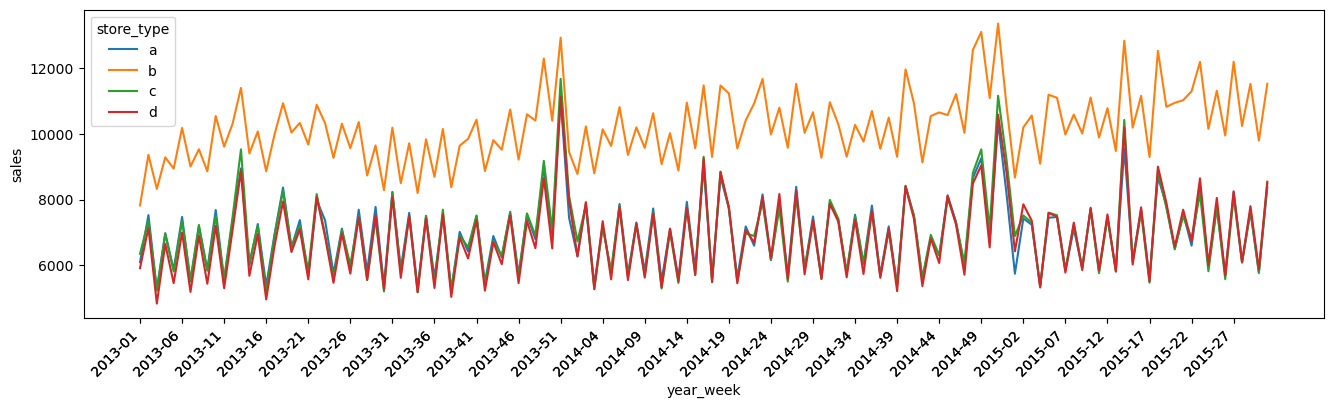

In [39]:
#Grouped by assortment and year_week, this finds the avg. sales
df_storetype_yearweek_group = df_store_open[['store_type', 'sales', 'year_week']].groupby(['store_type', 'year_week']).agg(sales = ('sales', "mean")).reset_index()

#Plotting the number of open stores on state holidays
plt.figure(figsize=(16,4))
sns.lineplot(data=df_storetype_yearweek_group, x = 'year_week', y = 'sales', hue = 'store_type')

step = 10  # Adjust the step size as needed
xticks = df_storetype_yearweek_group['year_week'][::step]
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(xticks, rotation=45, ha='right')

plt.show()

- Stores of type A are the most in numbers. Total sales and total customers are high for the store type A as it might have all the essential items required on a daily basis.
- Stores of type B is least in number but has highest average sales indicating these offer high-end products that target higher income individuals. The average of spending per customer is the least indicating only a few customers are buying such products, and others are just window shopping. Also, as the average customers per store type is higher for type B, these are the most crowded stores.
- Stores of type D has the highest spending per customer.
- Stores of type A, C, D have the similar trend of sales but store type D is way above the other three showing highest average sales.

### 3.3 Analysing Sales by Assortment

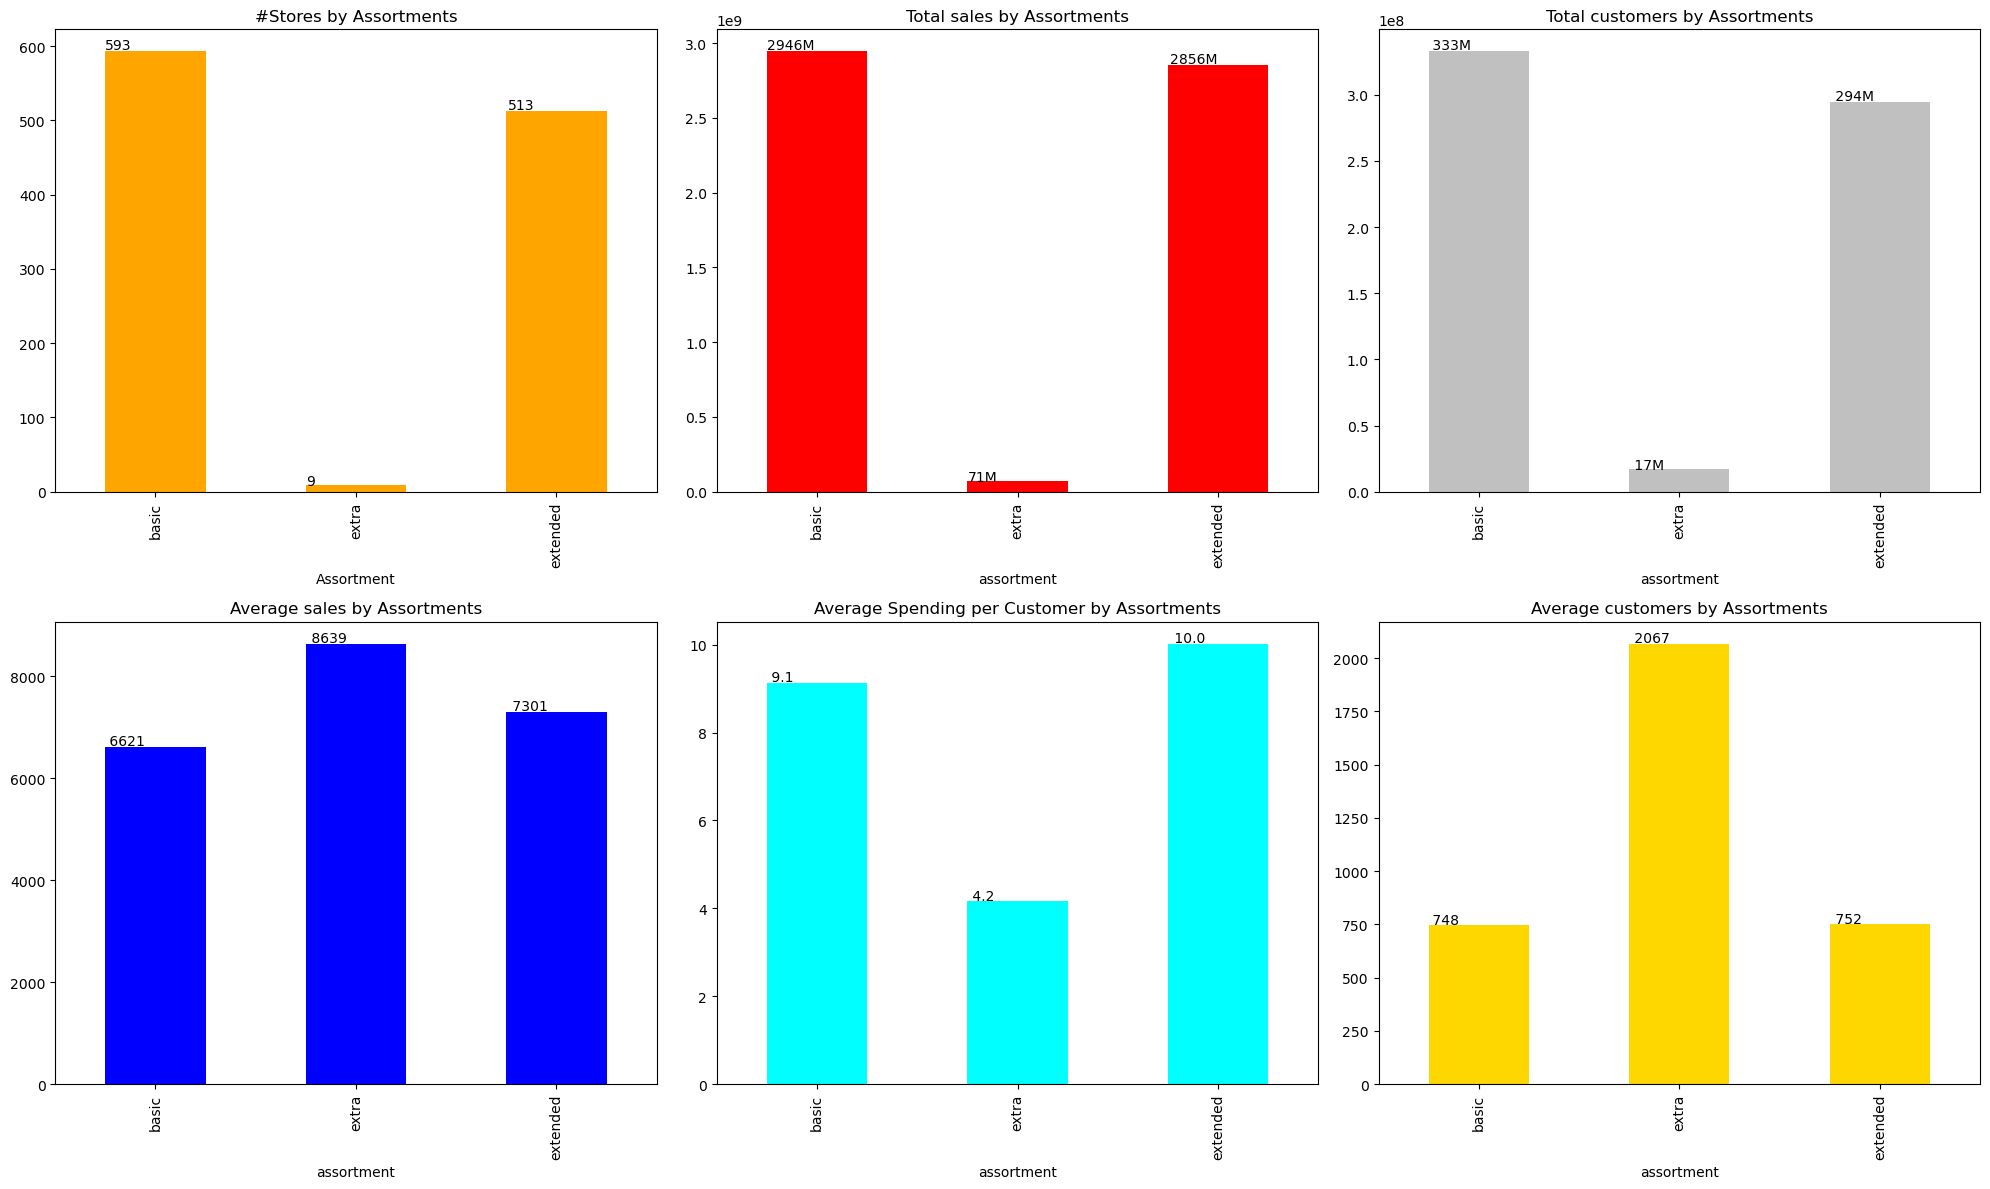

In [40]:
fig, ax = plt.subplots(2,3, figsize = (20,12))

# Custom x-tick labels
xticks_labels = {'a': 'basic', 'b': 'extra', 'c': 'extended'}

store_data.groupby('Assortment')['Store'].count().plot(kind = 'bar', ax=ax[0,0], title = '#Stores by Assortments', color = 'orange')
for bar in ax[0,0].patches:
    ax[0,0].annotate(f'{bar.get_height()}', (bar.get_x()*1.005, bar.get_height()*1.005))


df_store_open.groupby('assortment')['sales'].sum().plot(kind = 'bar', ax=ax[0,1], title = 'Total sales by Assortments', color = 'red')
for bar in ax[0,1].patches:
    height = bar.get_height()
    ax[0,1].annotate(f'{height/1e6 :.0f}M', (bar.get_x()*1.005, bar.get_height()*1.005))
    

df_store_open.groupby('assortment')['customers'].sum().plot(kind = 'bar', ax = ax[0,2], title = "Total customers by Assortments", color = 'silver')
for bar in ax[0,2].patches:
    height = bar.get_height()
    ax[0,2].annotate(f'{height/1e6 : .0f}M', (bar.get_x()*1.005, height*1.005))
    
    
df_store_open.groupby('assortment')['sales'].mean().plot(kind = 'bar', ax = ax[1,0], title = "Average sales by Assortments", color = 'blue')
for bar in ax[1,0].patches:
    ax[1,0].annotate(f'{bar.get_height() : .0f}', (bar.get_x()*1.005 , bar.get_height()*1.005 ))
    

df_store_open.groupby('assortment')['average_sales_per_customer'].mean().plot(kind = 'bar', ax = ax[1,1], title = "Average Spending per Customer by Assortments", color = 'cyan')
for bar in ax[1,1].patches:
    ax[1,1].annotate(f'{bar.get_height() : .1f}', (bar.get_x()*1.005 , bar.get_height()*1.005 ))
    
    
df_store_open.groupby('assortment')['customers'].mean().plot(kind = 'bar', ax = ax[1,2], title = "Average customers by Assortments", color = 'gold')
for bar in ax[1,2].patches:
    height = bar.get_height()
    ax[1,2].annotate(f'{height : .0f}', (bar.get_x()*1.005, height*1.005))
    
    
# Set x-tick labels in a loop
for axis in ax.flat:
    axis.set_xticklabels([xticks_labels[tick.get_text()] for tick in axis.get_xticklabels()])
    
plt.tight_layout()
plt.show()

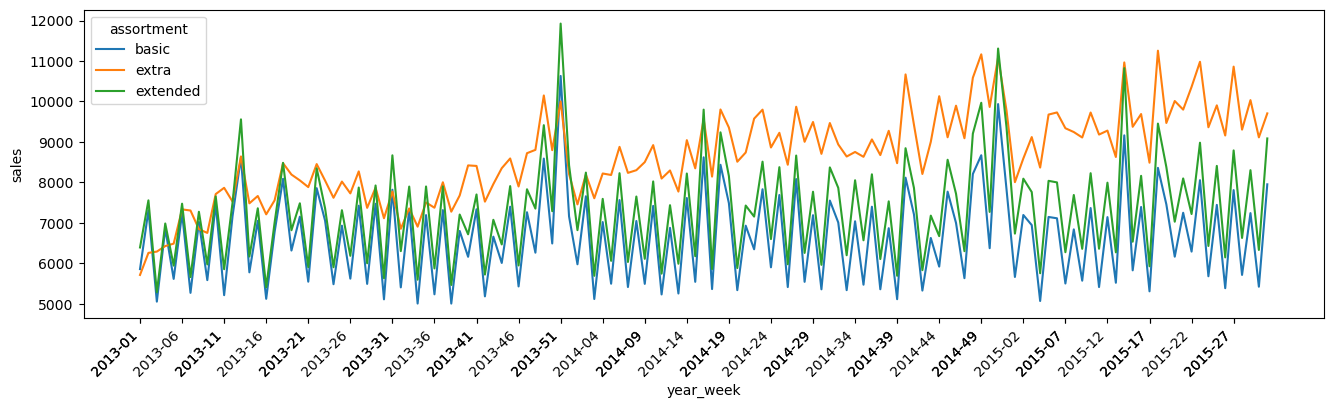

In [41]:
#Grouped by assortment and year_week, this finds the avg. sales
df_assortment_yearweek_group = df_store_open[['assortment', 'sales', 'year_week']].groupby(['assortment', 'year_week']).agg(sales = ('sales', "mean")).reset_index()

assortment_map = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
df_assortment_yearweek_group['assortment'] = df_assortment_yearweek_group['assortment'].map(assortment_map)

#Plotting the number of open stores on state holidays
plt.figure(figsize=(16,4))
sns.lineplot(data=df_assortment_yearweek_group, x = 'year_week', y = 'sales', hue = 'assortment')

step = 10  # Adjust the step size as needed
xticks = df_assortment_yearweek_group['year_week'][::step]
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(xticks, rotation=45, ha='right')

plt.show()

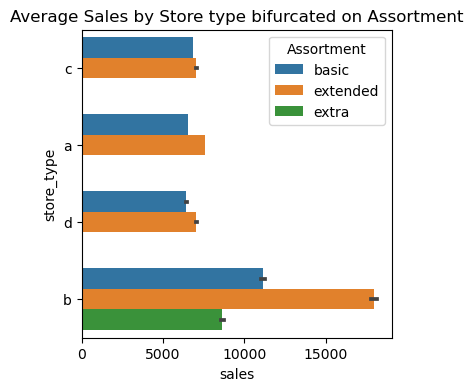

In [42]:
#Let's check the relationship between store type, assortment levels and sales
plt.figure(figsize=(4,4))
sns.barplot(data =df_store_open , y = "store_type",x = 'sales', hue = "assortment", orient='h')

# Getting the legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Mapping the labels to custom labels
label_mapping = {'a':'basic', 'b':'extra', 'c': 'extended'}
custom_labels = [label_mapping[label] for label in labels]

# Setting the custom legend
plt.legend(handles, custom_labels, title='Assortment', loc='best')

plt.title("Average Sales by Store type bifurcated on Assortment")
plt.show()

Assortments: Basic = Must buy products, Extended = Important product but not must buy, Extra = Includes all the product like one-stop market or sells only the premium products.

- Stores of Basic and extended assortments have highest total sales and total customers.
- Stores of Extra assortment has highest average sales although there are only 9 such stores. We note that all such <b>9 extra assortment stores come under the store type B</b>.
- Extended assortment store has highest average spending customer base.
- Over any time period, the highest to lowest average sales are in the order of Extra-Extended-Basic assortments.

### 3.4 Analysing sales by Promo, Promo2, is_promo features

In [43]:
df_store_open.head(1)

,store,day_of_week,date,sales,customers,promo,state_holiday,school_holiday,store_type,assortment,...,promo2,month,is_promo,average_sales_per_customer,day,year,week_of_year,year_week,competition_open,promo2_since
0,1,5,2015-07-31,5263,555,1,0,1,c,a,...,0,7,0,9.482883,31,2015,31,2015-31,82.0,31.0


In [44]:
df_store_open[[ 'promo', 'promo2', 'is_promo', 'promo2_since', 'sales']]

,promo,promo2,is_promo,promo2_since,sales
0,1,0,0,31.0,5263
1,1,1,1,278.0,6064
2,1,1,1,225.0,8314
3,1,0,0,31.0,13995
4,1,0,0,31.0,4822
...,...,...,...,...,...
1016776,0,0,0,1.0,3375
1016827,0,0,0,1.0,10765
1016863,0,1,1,5.0,5035
1017042,0,0,0,1.0,4491


In [45]:
df_promo = df_store_open.groupby(['promo', 'promo2', 'is_promo']).agg({'sales': 'mean'}).reset_index()
df_promo

,promo,promo2,is_promo,sales
0,0,0,0,6327.971557
1,0,1,0,5549.429241
2,0,1,1,5487.502622
3,1,0,0,8618.132880
4,1,1,0,7867.795984
5,1,1,1,7773.430056


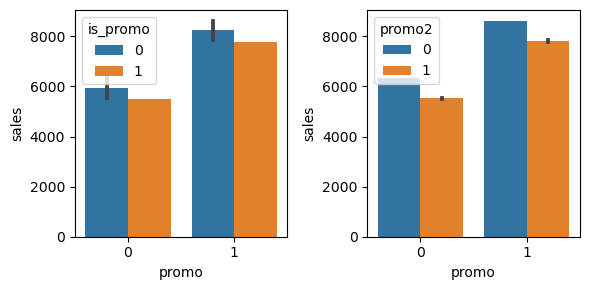

In [46]:
fig, ax = plt.subplots(1, 2, figsize = (6,3))

sns.barplot(data= df_promo, x = 'promo', y = 'sales', hue = 'is_promo', ax = ax[0])
sns.barplot(data = df_promo, x = 'promo', y = 'sales', hue = 'promo2', ax = ax[1])

plt.tight_layout()
plt.show()

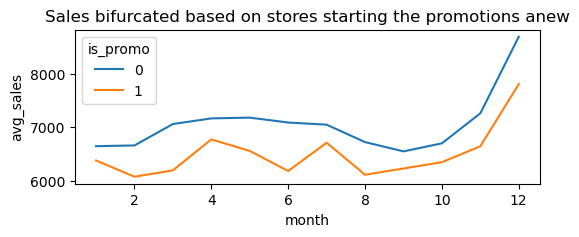

In [47]:
df_promo_month = df_store_open.groupby(['month', 'is_promo']).agg(avg_sales = ('sales', 'mean'), count_stores = ('store', 'count'), total_customers = ('customers', 'sum')).reset_index()

plt.figure(figsize=(6,2))
sns.lineplot(data= df_promo_month, x = 'month', y = 'avg_sales', hue = 'is_promo')
plt.title("Sales bifurcated based on stores starting the promotions anew")
plt.show()

- Sales are higher when daily promotions(i.e. promo = 1) are running on the stores.
- Infact the sales are higher whenever the stores are not participating in promo2(consecutive promotions). And, even if new promotions are running in a month(i.e., is_promo =1), stores participating in promo2 have lower sales when compared with non-participating ones. Clearly, the 'promo2' on promo months type of promotions are not working.

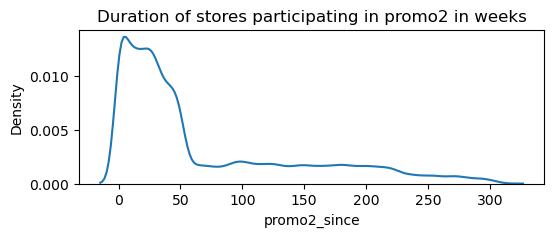

In [49]:
plt.figure(figsize=(6,2))
sns.kdeplot(data=df_store_open, x='promo2_since')
plt.title("Duration of stores participating in promo2 in weeks")
plt.show()

Most stores joined the promo2 in the last 1.5 years(considering today is June 2015). As we can see that stores with promo2 are as old as 5 to 6 years.

### 3.5 Analysing sales by competition_distance, competition_open_since

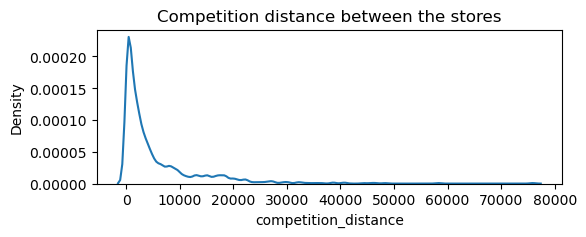

In [50]:
plt.figure(figsize=(6,2))
sns.kdeplot(data=df_store_open, x='competition_distance')
plt.title("Competition distance between the stores")
plt.show()

Let us analyze the sales and stores by binning the competition_distance.

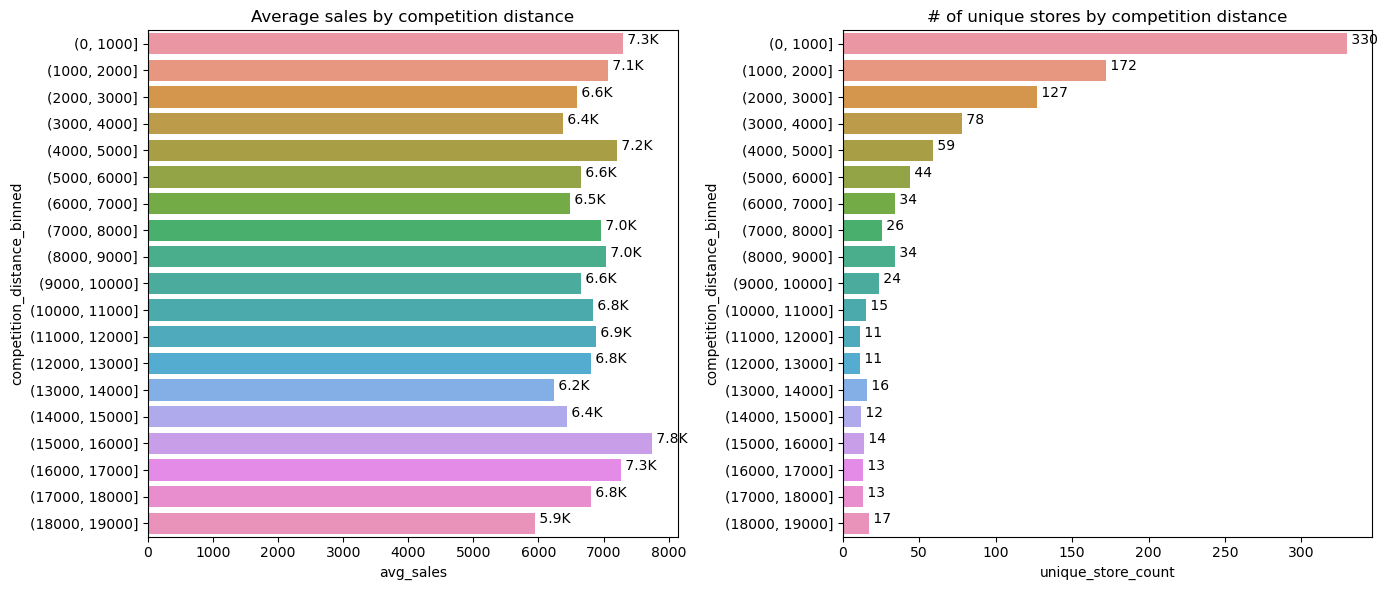

In [51]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

#Considering store, competition_distance, sales
df_comp_dist = df_store_open[['store', 'competition_distance', 'sales']]
bins = np.arange(0, 20000, 1000)

#Binning the competition_distance, and grouping by bins to find the avg_sales, total_sales, unique_store_count.
df_comp_dist['competition_distance_binned'] = pd.cut(df_comp_dist['competition_distance'], bins = bins)
df_comp_dist_grouped = df_comp_dist.groupby('competition_distance_binned').agg(total_sales = ('sales', sum), avg_sales = ('sales', "mean"), unique_store_count=('store', 'nunique')).reset_index()

#Plotting the horizontal bars of avg_sales
sns.barplot(y = 'competition_distance_binned', x = 'avg_sales', data = df_comp_dist_grouped, ax = ax[0])
ax[0].set_title ('Average sales by competition distance')
for bar in ax[0].patches:
    ax[0].annotate(f'{bar.get_width()/1e3 : .1f}K', (bar.get_width(), bar.get_y() + bar.get_height() / 2))


#Plotting the horizontal bars of unique_store_count
sns.barplot(y = 'competition_distance_binned', x = 'unique_store_count', data = df_comp_dist_grouped, ax = ax[1])
ax[1].set_title ('# of unique stores by competition distance')
for bar in ax[1].patches:
    ax[1].annotate(f'{bar.get_width() : .0f}', (bar.get_width(), bar.get_y() + bar.get_height() / 2))

plt.tight_layout()

- Nearly, 1/4th of all the stores of XYZ are located within a Km. 
- The total sales and total customers exhibit exact same pattern as in the graph "# of unique stores by competition distance".
- In general, stores that are located with 1 km saw highest total sales.

### 3.6 Analysing day_of_week sales, monthly sales, and yearly sales 

## 4. Data Preparation for Model Building

### 4.1 Splitting the data into 80:20 ratio

Let us split the data into training and testing sets before applying any transformations.

In [263]:
# Define the last date in the dataset
last_date = df_store_open['date'].max()

# Define the cutoff date for the last 26 weeks which is approximately 6 months
cutoff_date = last_date - pd.Timedelta(weeks=26)

# Split the data into training and test sets
train_data = df_store_open[df_store_open['date'] <= cutoff_date]
test_data = df_store_open[df_store_open['date'] > cutoff_date]

In [264]:
print(f"The shape of the train data is {train_data.shape} and the test data is {test_data.shape}. \
The size of the test data is{test_data.shape[0]/df_store_open.shape[0] * 100 : .0f}%.")

The shape of the train data is (676009, 21) and the test data is (168383, 21). The size of the test data is 20%.


### 4.2 Dropping the columns used temporarily for data analysis

In [265]:
# Drop the 'year_week', 'average_sales_per_customer', and 'date' columns
columns_to_drop = ['year_week', 'average_sales_per_customer', 'date']
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

### 4.3 Converting non-numerical columns to numerical columns

In [266]:
# One-hot encode 'state_holiday'
train_data = pd.get_dummies(train_data, columns=['state_holiday'])
test_data = pd.get_dummies(test_data, columns=['state_holiday'])

In [267]:
print(f"The training set has {len(train_data.columns)} columns and testing set has {len(test_data.columns)} columns")

The training set has 21 columns and testing set has 20 columns


To ensure both train and test sets have the same columns after one-hot encoding, let us use DataFrame.align method to align both train and test sets vertically(axis = 1) with 'outer' join so that all the columns are present from both dataframes. In our case, test_data does not have 'state_holiday_c' column. This will be included and filled with 0's in the test set.

In [268]:
# Ensure both train and test sets have the same columns after one-hot encoding
train_data, test_data = train_data.align(test_data, join='outer', axis=1, fill_value=0)

In [269]:
# Label encode 'store_type'
label_encoder = LabelEncoder()
train_data['store_type'] = label_encoder.fit_transform(train_data['store_type'])
test_data['store_type'] = label_encoder.transform(test_data['store_type'])

In [270]:
# Apply assortment dictionary to 'assortment'
assortment_dict = {'a': 1, 'b': 2, 'c': 3}
train_data['assortment'] = train_data['assortment'].map(assortment_dict)
test_data['assortment'] = test_data['assortment'].map(assortment_dict)

In [272]:
train_data['customers'].isnull().sum()

0

In [273]:
# Function to add cyclical features
def add_cyclical_features(df, column, max_value):
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max_value)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max_value)
    return df

In [274]:
# Apply cyclical transformations
train_data = add_cyclical_features(train_data, 'month', 12)
train_data = add_cyclical_features(train_data, 'day_of_week', 7)
train_data = add_cyclical_features(train_data, 'day', 31)
train_data = add_cyclical_features(train_data, 'week_of_year', 52)

test_data = add_cyclical_features(test_data, 'month', 12)
test_data = add_cyclical_features(test_data, 'day_of_week', 7)
test_data = add_cyclical_features(test_data, 'day', 31)
test_data = add_cyclical_features(test_data, 'week_of_year', 52)

In [275]:
# Drop the original cyclical columns
cyclical_columns_to_drop = ['month', 'day_of_week', 'day', 'week_of_year']
train_data = train_data.drop(columns=cyclical_columns_to_drop)
test_data = test_data.drop(columns=cyclical_columns_to_drop)

### 4.5 Checking and transforming features that are left/right skewed

Let us check the distribution of continuous numerical columns. If they are not normally distributed, we will use transformations.

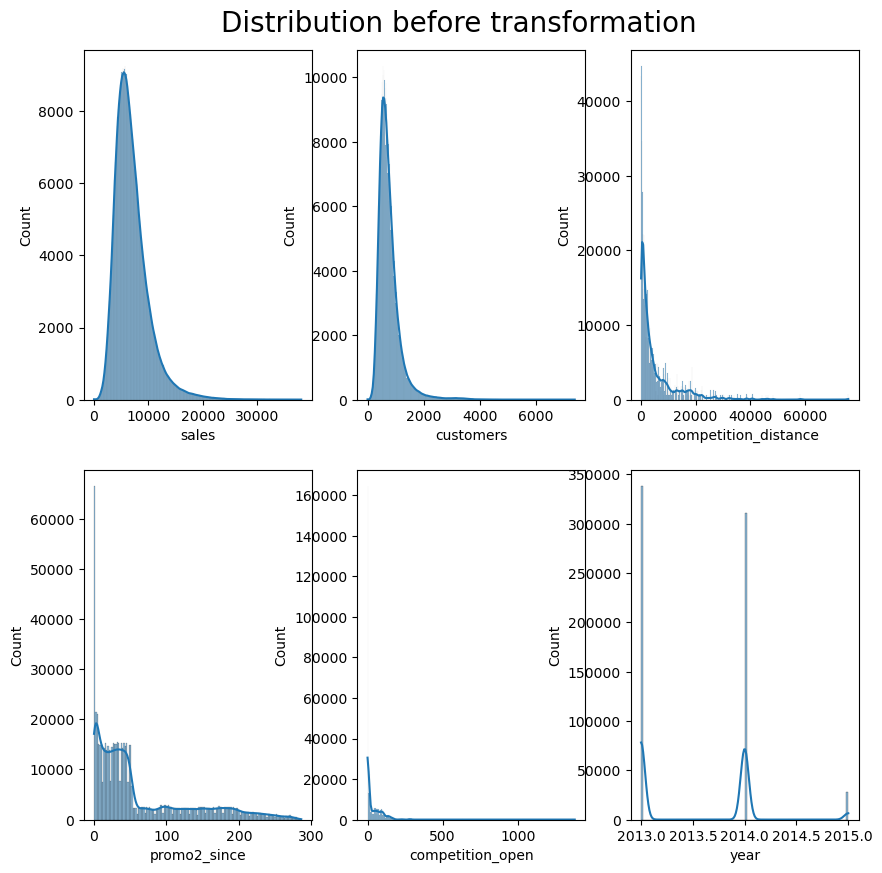

In [276]:
fig, ax = plt.subplots(2, 3, figsize=(10,6)) #Create 2x3 subplots as there are 12 columns

# Flatten the axes
ax = ax.flatten()

for i, column in enumerate(train_data[[ 'sales', 'customers', 'competition_distance', 'promo2_since', 'competition_open', 'year']]):
    sns.histplot(train_data[column], kde = True, ax = ax[i])
    
plt.suptitle('Distribution before transformation', y = 0.92, fontsize = 20)
plt.show()

In [277]:
# Apply sqrt transformation to 'sales'
train_data['sales'] = np.sqrt(train_data['sales'])
test_data['sales'] = np.sqrt(test_data['sales'])

# Apply sqrt transformation to 'customers'
train_data['customers'] = np.sqrt(train_data['customers'])
test_data['customers'] = np.sqrt(test_data['customers'])

# Apply log1p transformation to 'competition_distance'
train_data['competition_distance'] = np.log1p(train_data['competition_distance'])
test_data['competition_distance'] = np.log1p(test_data['competition_distance'])

# Apply log transformation with a small constant to handle zeros in 'competition_open' and 'promo2_since'
small_constant = 1
train_data['competition_open'] = np.log1p(train_data['competition_open'] + small_constant)
test_data['competition_open'] = np.log1p(test_data['competition_open'] + small_constant)

train_data['promo2_since'] = np.log1p(train_data['promo2_since'] + small_constant)
test_data['promo2_since'] = np.log1p(test_data['promo2_since'] + small_constant)

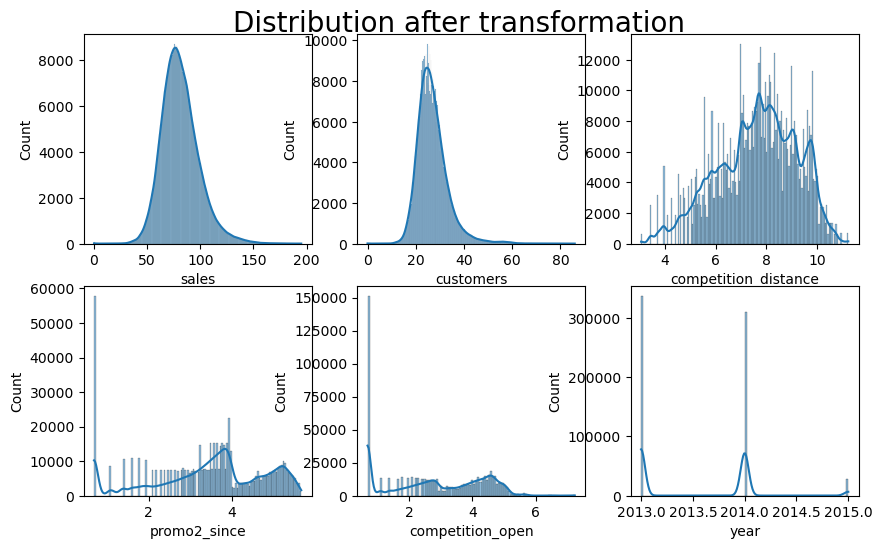

In [278]:
fig, ax = plt.subplots(2, 3, figsize=(10,6)) #Create 4x3 subplots as there are 12 columns

# Flatten the axes
ax = ax.flatten()

for i, column in enumerate(train_data[[ 'sales', 'customers', 'competition_distance', 'promo2_since', 'competition_open', 'year']]):
    sns.histplot(train_data[column], kde = True, ax = ax[i])
    
plt.suptitle('Distribution after transformation', y = 0.92, fontsize = 20)
plt.show()

### 4.4 Standardization and Normalization

In [279]:
# Initialize scalers
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

In [280]:
# Apply MinMaxScaler to competition_open , year and promo2_since
train_data[['year', 'promo2_since']] = minmax_scaler.fit_transform(train_data[['year', 'promo2_since']])
test_data[['year', 'promo2_since']] = minmax_scaler.transform(test_data[['year', 'promo2_since']])

In [286]:
train_data[['competition_distance', 'competition_open']] = minmax_scaler.fit_transform(train_data[['competition_distance', 'competition_open']])
test_data[['competition_distance', 'competition_open']] = minmax_scaler.transform(test_data[['competition_distance', 'competition_open']])

In [281]:
train_data['customers'].isnull().sum()

0

In [282]:
# Apply StandardScaler to customers as it follows normal kind of distribution
train_data[['customers']] = standard_scaler.fit_transform(train_data[['customers']])
test_data[['customers']] = standard_scaler.transform(test_data[['customers']])

- Instead of applying the standardization to competition_distance and competition_open, we will directly apply the log/sqrt transformations which brings them on the similar scale as well as reduces the effect of outliers.
- Note that we have not applied standardization to the target variable.

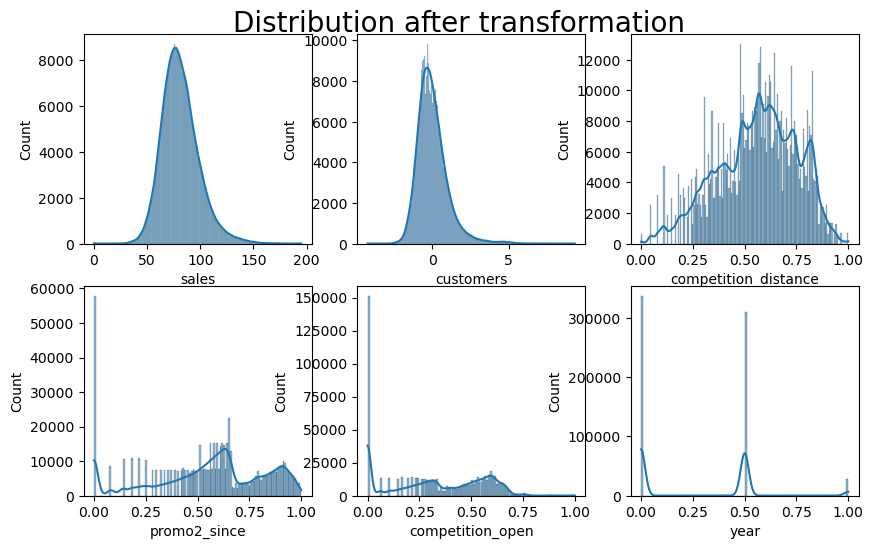

In [287]:
fig, ax = plt.subplots(2, 3, figsize=(10,6)) #Create 4x3 subplots as there are 12 columns

# Flatten the axes
ax = ax.flatten()

for i, column in enumerate(train_data[[ 'sales', 'customers', 'competition_distance', 'promo2_since', 'competition_open', 'year']]):
    sns.histplot(train_data[column], kde = True, ax = ax[i])
    
plt.suptitle('Distribution after transformation', y = 0.92, fontsize = 20)
plt.show()

In [318]:
# Separate features and target variable
X_train = train_data.drop(columns=['sales'])
y_train = train_data['sales']
X_test = test_data.drop(columns=['sales'])
y_test = test_data['sales']

In [319]:
X_train

,assortment,competition_distance,competition_open,customers,is_promo,promo,promo2,promo2_since,school_holiday,state_holiday_0,...,store_type,year,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
202930,1,0.500851,0.560337,-0.330639,0,1,0,0.252074,0,1,...,2,1.0,0.5,0.866025,-0.974928,-0.222521,-0.201299,0.97953,0.568065,0.822984
202931,1,0.403175,0.578787,-0.305287,1,1,1,0.974722,0,1,...,0,1.0,0.5,0.866025,-0.974928,-0.222521,-0.201299,0.97953,0.568065,0.822984
202932,1,0.794860,0.596802,-0.138244,1,1,1,0.927632,0,1,...,0,1.0,0.5,0.866025,-0.974928,-0.222521,-0.201299,0.97953,0.568065,0.822984
202933,3,0.413422,0.534786,2.127978,0,1,0,0.252074,0,1,...,2,1.0,0.5,0.866025,-0.974928,-0.222521,-0.201299,0.97953,0.568065,0.822984
202934,1,0.886394,0.000000,-0.327461,0,1,0,0.252074,0,1,...,0,1.0,0.5,0.866025,-0.974928,-0.222521,-0.201299,0.97953,0.568065,0.822984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,1,0.240811,0.560337,-0.492971,0,0,0,0.081586,1,0,...,1,0.0,0.5,0.866025,0.974928,-0.222521,0.201299,0.97953,0.120537,0.992709
1016827,2,0.453309,0.671178,3.446791,0,0,0,0.081586,1,0,...,1,0.0,0.5,0.866025,0.974928,-0.222521,0.201299,0.97953,0.120537,0.992709
1016863,2,0.450440,0.000000,1.327679,1,0,1,0.252074,1,0,...,1,0.0,0.5,0.866025,0.974928,-0.222521,0.201299,0.97953,0.120537,0.992709
1017042,2,0.515324,0.000000,0.839462,0,0,0,0.081586,1,0,...,1,0.0,0.5,0.866025,0.974928,-0.222521,0.201299,0.97953,0.120537,0.992709


In [320]:
# Calculate VIF for each feature
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

In [321]:
#Let's ensure all columns in X_train are of type float64
X_train_vif = X_train.astype('float64')
X_test_vif = X_test.astype('float64')

# Calculate initial VIF
vif_data = calculate_vif(X_train_vif)
print(vif_data)

                 feature        VIF
0             assortment   1.094017
1   competition_distance   1.205530
2       competition_open   1.087958
3              customers   1.288470
4               is_promo   1.256995
5                  promo   1.182410
6                 promo2   1.457639
7           promo2_since   1.236143
8         school_holiday   1.107495
9        state_holiday_0  24.510822
10       state_holiday_a   1.021764
11       state_holiday_b   1.005413
12       state_holiday_c   1.004603
13                 store   1.003942
14            store_type   1.145039
15                  year   1.124736
16             month_sin  42.159992
17             month_cos  44.453909
18       day_of_week_sin   1.061695
19       day_of_week_cos   1.084030
20               day_sin   1.008817
21               day_cos   1.016691
22      week_of_year_sin  40.849798
23      week_of_year_cos  45.767615


In [322]:
# Iteratively remove features with high VIF
threshold_vif = 5  # Set a threshold value for VIF
while vif_data['VIF'].max() > threshold_vif:
    high_vif_feature = vif_data.sort_values('VIF', ascending=False).iloc[0]['feature']
    X_train_vif = X_train_vif.drop(columns=[high_vif_feature])
    vif_data = calculate_vif(X_train_vif)
    print(vif_data)
    print("--------------"*6)

                 feature        VIF
0             assortment   1.094016
1   competition_distance   1.205527
2       competition_open   1.087943
3              customers   1.288468
4               is_promo   1.256963
5                  promo   1.182034
6                 promo2   1.457631
7           promo2_since   1.236122
8         school_holiday   1.106731
9        state_holiday_0  24.502362
10       state_holiday_a   1.021629
11       state_holiday_b   1.005413
12       state_holiday_c   1.004591
13                 store   1.003942
14            store_type   1.145039
15                  year   1.124078
16             month_sin  40.071132
17             month_cos   2.218373
18       day_of_week_sin   1.060422
19       day_of_week_cos   1.083780
20               day_sin   1.006763
21               day_cos   1.016622
22      week_of_year_sin  40.748590
------------------------------------------------------------------------------------
                 feature        VIF
0             a

In [323]:
# Update X_train and X_test to only include features with acceptable VIF
X_train_vif = X_train[X_train_vif.columns]
X_test_vif = X_test[X_train_vif.columns]

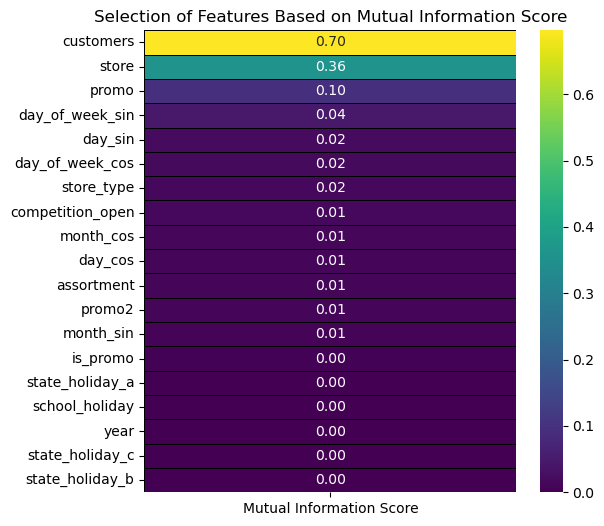

In [324]:
# Select top K features using SelectKBest
#k = 10  # Number of top features to select
select_k_best = SelectKBest(score_func=mutual_info_regression, k='all')
fit = select_k_best.fit(X_train_vif, y_train)

# Create a DataFrame with feature scores
feature_scores = pd.DataFrame(data=fit.scores_, index=X_train_vif.columns, columns=['Mutual Information Score'])

# Plot the feature scores
plt.subplots(figsize=(6,6))
sns.heatmap(feature_scores.sort_values(by='Mutual Information Score', ascending=False), annot=True, cmap='viridis', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Selection of Features Based on Mutual Information Score')
plt.show()

Clearly, is_promo, year, school_holiday, and state_holiday columns does not provide any useful information for predicting the target. Thus, it means that there is no dependency between the feature and the target variable.

In [325]:
# Identify features with zero mutual information
zero_mi_features = feature_scores[feature_scores['Mutual Information Score'] < 0.005].index.tolist()

# Print the features with zero mutual information
print("Features with zero mutual information:")
print(zero_mi_features)

Features with zero mutual information:
['is_promo', 'school_holiday', 'state_holiday_a', 'state_holiday_b', 'state_holiday_c', 'year']


In [326]:
# Drop features with zero mutual information
X_train_vif_mi = X_train_vif.drop(columns=zero_mi_features)
X_test_vif_mi = X_test_vif.drop(columns=zero_mi_features)

In [310]:
# from sklearn.ensemble import RandomForestRegressor

# # Train a RandomForest model
# model = RandomForestRegressor(n_estimators=50, random_state=42)
# model.fit(X_train_vif, y_train)

# # Get feature importances
# importances = model.feature_importances_
# feature_importances = pd.DataFrame({'Feature': X_train_vif.columns, 'Importance': importances})

# # Sort and plot feature importances
# feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
# plt.figure(figsize=(10,8))
# sns.barplot(x='Importance', y='Feature', data=feature_importances)
# plt.title('Feature Importances from RandomForest')
# plt.show()

Above code is running for a very long time. Due to which we will revisit this part later if required.

In [328]:
X_train_vif_mi.head()

,assortment,competition_open,customers,promo,promo2,store,store_type,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos
202930,1,0.560337,-0.330639,1,0,1,2,0.5,0.866025,-0.974928,-0.222521,-0.201299,0.97953
202931,1,0.578787,-0.305287,1,1,2,0,0.5,0.866025,-0.974928,-0.222521,-0.201299,0.97953
202932,1,0.596802,-0.138244,1,1,3,0,0.5,0.866025,-0.974928,-0.222521,-0.201299,0.97953
202933,3,0.534786,2.127978,1,0,4,2,0.5,0.866025,-0.974928,-0.222521,-0.201299,0.97953
202934,1,0.000000,-0.327461,1,0,5,0,0.5,0.866025,-0.974928,-0.222521,-0.201299,0.97953


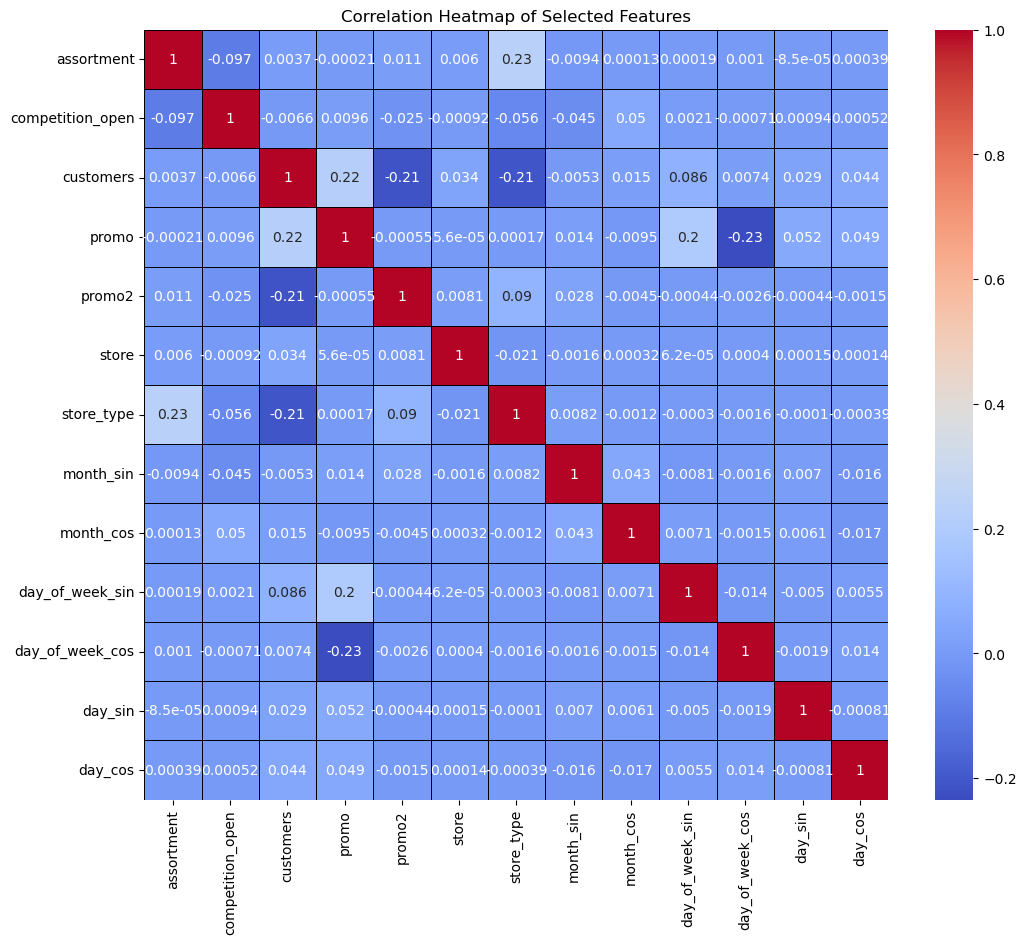

In [330]:
# Calculate the correlation matrix
correlation_matrix = X_train_vif_mi.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

Clearly, there is no multicollinearity between the features; which is one of the assumptions of linear regression.

## Model Building

In [367]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model on the training data
lr_model.fit(X_train_vif_mi, y_train)

# Make predictions on the training data
y_train_pred_lr = lr_model.predict(X_train_vif_mi)

# Make predictions on the test data
y_test_pred_lr = lr_model.predict(X_test_vif_mi)

In [368]:
# Reverse the sqrt transformation by squaring the values
y_train_original = np.square(y_train)
y_train_pred_original_lr = np.square(y_train_pred_lr)
y_test_original = np.square(y_test)
y_test_pred_original_lr = np.square(y_test_pred_lr)


#Training set
# Calculate MAE, RMSE, R^2 for training data on original scale
mae_train = mean_absolute_error(y_train_original, y_train_pred_original_lr)
rmse_train = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original_lr))
r2_train = r2_score(y_train_original, y_train_pred_original_lr)

# Calculate MAPE for training data excluding zero sales
mape_train = np.mean(np.abs((y_train_original[y_train_original != 0] - y_train_pred_original_lr[y_train_original != 0]) / y_train_original[y_train_original != 0])) * 100

# Calculate Adjusted R^2 for training data
n_train = X_train_vif_mi.shape[0]
p_train = X_train_vif_mi.shape[1]
adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)


#Testing set
# Calculate MAE, RMSE, R^2 for test data on original scale
mae_test = mean_absolute_error(y_test_original, y_test_pred_original_lr)
rmse_test = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original_lr))
r2_test = r2_score(y_test_original, y_test_pred_original_lr)

# Calculate MAPE for test data excluding zero sales
mape_test = np.mean(np.abs((y_test_original[y_test_original != 0] - y_test_pred_original_lr[y_test_original != 0]) / y_test_original[y_test_original != 0])) * 100

# Calculate Adjusted R^2 for test data
n_test = X_test_vif_mi.shape[0]
p_test = X_test_vif_mi.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)



# Compile results into a DataFrame
results_lr = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R^2', 'Adjusted R^2'],
    'Train Score': [mae_train, rmse_train, mape_train, r2_train, adjusted_r2_train],
    'Test Score': [mae_test, rmse_test, mape_test, r2_test, adjusted_r2_test]
})

# Display the results
print(results_lr)

         Metric  Train Score   Test Score
0           MAE  1002.102206  1054.215988
1          RMSE  1473.347530  1554.348789
2          MAPE    14.956308    14.404760
3           R^2     0.776026     0.742437
4  Adjusted R^2     0.776022     0.742417


In [373]:
# Reconstruct the date columns for train and test
train_dates = df_store_open[df_store_open['date'] <= cutoff_date]['date']
test_dates = df_store_open[df_store_open['date'] > cutoff_date]['date']
train_stores = df_store_open[df_store_open['date'] <= cutoff_date]['store']
test_stores = df_store_open[df_store_open['date'] > cutoff_date]['store']


# Create DataFrames with the original scale sales and dates for train and test sets
train_results = pd.DataFrame({
    'Date': train_dates,
    'Store': train_stores,
    'Actual Sales': y_train_original,
    'Predicted Sales': y_train_pred_original_lr
})

test_results = pd.DataFrame({
    'Date': test_dates,
    'Store': test_stores,
    'Actual Sales': y_test_original,
    'Predicted Sales': y_test_pred_original_lr
})

In [379]:
# Function to plot sales for a specific store
def plot_sales_for_store(store_id, time_window_days=45):
    # Filter the test_results DataFrame to include only the specified store and the last `time_window_days`
    test_results_filtered = test_results[(test_results['Store'] == store_id)]
    end_date = test_results_filtered['Date'].max()
    start_date = end_date - pd.Timedelta(days=time_window_days)
    test_results_filtered = test_results_filtered[test_results_filtered['Date'] >= start_date]

    # Plot the original sales vs. predicted sales for the filtered test set using seaborn
    plt.figure(figsize=(12, 3))
    sns.lineplot(data=test_results_filtered, x='Date', y='Actual Sales', label='Actual Sales', color='blue')
    sns.lineplot(data=test_results_filtered, x='Date', y='Predicted Sales', label='Predicted Sales', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Actual vs Predicted Sales for Store {store_id}')
    plt.legend()
    plt.show()

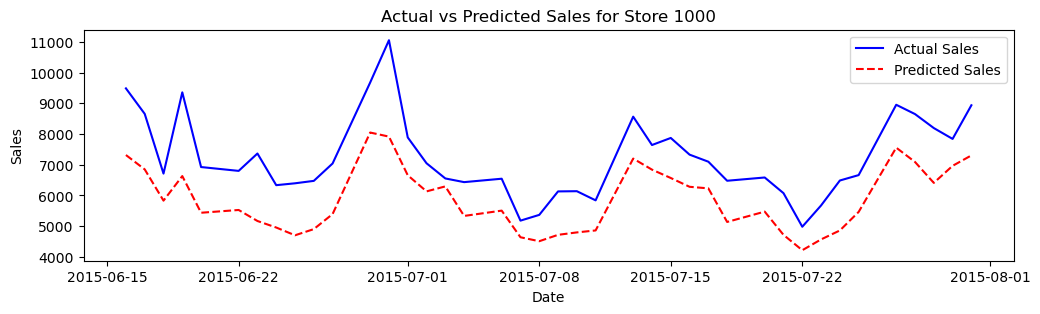

In [380]:
#Plot sales for a specific store
store_id = 1000
plot_sales_for_store(store_id)

In [370]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model on the training data
rf_model.fit(X_train_vif_mi, y_train)

# Make predictions on the training data
y_train_pred_rf = rf_model.predict(X_train_vif_mi)

# Make predictions on the test data
y_test_pred_rf = rf_model.predict(X_test_vif_mi)

In [371]:
# Reverse the sqrt transformation by squaring the values
y_train_original = np.square(y_train)
y_train_pred_original_rf = np.square(y_train_pred_rf)
y_test_original = np.square(y_test)
y_test_pred_original_rf = np.square(y_test_pred_rf)


# Calculate MAE, RMSE, R^2 for training data on original scale
mae_train_rf = mean_absolute_error(y_train_original, y_train_pred_original_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original_rf))
r2_train_rf = r2_score(y_train_original, y_train_pred_original_rf)

# Calculate MAPE for training data excluding zero sales
mape_train_rf = np.mean(np.abs((y_train_original[y_train_original != 0] - y_train_pred_original_rf[y_train_original != 0]) / y_train_original[y_train_original != 0])) * 100

# Calculate Adjusted R^2 for training data
n_train = X_train_vif_mi.shape[0]
p_train = X_train_vif_mi.shape[1]
adjusted_r2_train_rf = 1 - (1 - r2_train_rf) * (n_train - 1) / (n_train - p_train - 1)



# Calculate MAE, RMSE, R^2 for test data on original scale
mae_test_rf = mean_absolute_error(y_test_original, y_test_pred_original_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original_rf))
r2_test_rf = r2_score(y_test_original, y_test_pred_original_rf)

# Calculate MAPE for test data excluding zero sales
mape_test_rf = np.mean(np.abs((y_test_original[y_test_original != 0] - y_test_pred_original_rf[y_test_original != 0]) / y_test_original[y_test_original != 0])) * 100

# Calculate Adjusted R^2 for test data
n_test = X_test_vif_mi.shape[0]
p_test = X_test_vif_mi.shape[1]
adjusted_r2_test_rf = 1 - (1 - r2_test_rf) * (n_test - 1) / (n_test - p_test - 1)



# Compile results into a DataFrame
results_rf = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R^2', 'Adjusted R^2'],
    'Train Score': [mae_train_rf, rmse_train_rf, mape_train_rf, r2_train_rf, adjusted_r2_train_rf],
    'Test Score': [mae_test_rf, rmse_test_rf, mape_test_rf, r2_test_rf, adjusted_r2_test_rf]
})

# Display the results
print(results_rf)

         Metric  Train Score  Test Score
0           MAE   137.029236  491.440403
1          RMSE   217.204529  723.517404
2          MAPE     2.005246    6.826912
3           R^2     0.995132    0.944194
4  Adjusted R^2     0.995132    0.944189


In [381]:
# Create DataFrames with the original scale sales, dates, and stores for train and test sets
train_results = pd.DataFrame({
    'Date': train_dates,
    'Store': train_stores,
    'Actual Sales': y_train_original,
    'Predicted Sales': y_train_pred_original_rf
})

test_results = pd.DataFrame({
    'Date': test_dates,
    'Store': test_stores,
    'Actual Sales': y_test_original,
    'Predicted Sales': y_test_pred_original_rf
})

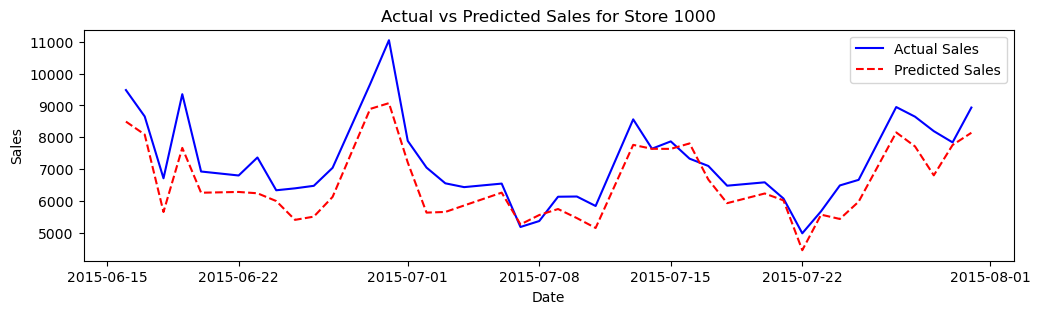

In [383]:
# Example usage: Plot sales for a specific store
store_id = 1000  # Replace with the store ID you want to visualize
plot_sales_for_store(store_id)